https://simpletransformers.ai/docs/binary-classification/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 31.7 MB/s 
     |████████████████████████████████| 101 kB 12.8 MB/s 
     |████████████████████████████████| 6.6 MB 59.4 MB/s 
     |████████████████████████████████| 596 kB 64.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoModel, AutoTokenizer

from distutils.version import LooseVersion as LV

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

import io

import pandas as pd
import numpy as np
import itertools

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import LabelEncoder


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 1.11.0+cu113 Device: cuda [Tesla T4]


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
df_test = pd.read_csv("/content/drive/Shareddrives/TextAnalytics_project/dataset_ironita_2018/Data/processed_text_test.csv")
df_train = pd.read_csv("/content/drive/Shareddrives/TextAnalytics_project/dataset_ironita_2018/Data/processed_text_train.csv")

In [ ]:
df_train.head()

,id,text,irony,sarcasm,topic,lemmatized_text,cleaned_text,cleaned_text_mention_hashtag
0,8.111568e+17,"Zurigo, trovato morto il presunto autore della...",0.0,0.0,HSC,Zurigo trovare morire presumere autore sparato...,zurigo trovato morto presunto autore sparatori...,zurigo trovato morto presunto autore sparatori...
1,8.111831e+17,"Zurigo, trovato morto il presunto autore della...",0.0,0.0,HSC,Zurigo trovare morire presumere autore sparato...,zurigo trovato morto presunto autore sparatori...,zurigo trovato morto presunto autore sparatori...
2,8.263806e+17,"Zingari..i soliti ""MERDOSI""..#cacciamolivia Ro...",0.0,0.0,HSC,zingaro solito merdoso #cacciamolivia Roma rom...,zingari soliti merdosi #cacciamolivia roma rom...,zingari soliti merdosi @hashtag roma rom aggre...
3,8.448712e+17,"Zingari di merda,tutti al muro...bastardi Spar...",0.0,0.0,HSC,zingaro merda muro bastardo sparare carabinier...,zingari merda muro bastardi sparano carabinier...,zingari merda muro bastardi sparano carabinier...
4,5.097128e+17,zero notizie decreto #tfaordinario II ciclo ze...,1.0,0.0,TW-BS,zero notizia decreto #tfaordinario II ciclo ze...,zero notizie decreto #tfaordinario ii ciclo ze...,zero notizie decreto @hashtag ii ciclo zero no...


In [ ]:
X_train = df_train['text']
y_train = df_train[['irony','sarcasm']].values
X_test = df_test['text']
y_test = df_test[['irony','sarcasm']].values

Encoding target variable

In [ ]:
labels_train= y_train.sum(axis=1)
labels_test= y_test.sum(axis=1)

# Preparation of text

[CLS] denote the beginning of a tweet

In [ ]:
sentences_train = ["[CLS] " + s for s in X_train]
sentences_test = ["[CLS] " + s for s in X_test]

We decided to use **bert-base-italian-cased** because we have Italian tweets

In [ ]:
model_name = "dbmdz/bert-base-italian-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
model = AutoModel.from_pretrained(model_name)
tokenizer

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PreTrainedTokenizerFast(name_or_path='dbmdz/bert-base-italian-cased', vocab_size=31102, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

Tokenization of test and train

In [ ]:
tokenized_train = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]
tokenized_test  = [tokenizer.tokenize(s) for s in tqdm(sentences_test)]

100%|██████████| 872/872 [00:00<00:00, 6367.99it/s]


In [ ]:
print("Tokenized tweet: ", (tokenized_train[38]) )
print("Original tweet: ", X_train.values[38])

Tokenized tweet:  ['[CLS]', 'visto', 'che', 'una', 'possibilita', 'l', "'", 'abbiamo', 'data', 'a', 'tutti', 'i', 'mafi', '##osi', 'disponibili', 'non', 'vedo', 'perche', 'non', 'dovremmo', 'ora', 'dar', '##la', 'anche', 'a', '#', 'gri', '##llo', '.', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP']
Original tweet:  Visto che una possibilità l'abbiamo data a tutti i mafiosi disponibili non vedo perchè non dovremmo ora darla anche a #Grillo .


Set the maximum lengths (BERT have a maximum number of token we can pass)

and add [SEP] at the end of the sentence

In [ ]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 512

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['SEP'] for t in tokenized_train]
tokenized_test  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test]

print ("The truncated tokenized first training sentence:")
print (tokenized_train[38])

The truncated tokenized first training sentence:
['[CLS]', 'visto', 'che', 'una', 'possibilita', 'l', "'", 'abbiamo', 'data', 'a', 'tutti', 'i', 'mafi', '##osi', 'disponibili', 'non', 'vedo', 'perche', 'non', 'dovremmo', 'ora', 'dar', '##la', 'anche', 'a', '#', 'gri', '##llo', '.', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP', 'SEP']


In [ ]:
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, MAX_LEN_TRAIN-len(i)),
                             mode='constant') for i in ids_train])

ids_test = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test]
ids_test = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test])

print ("The indices of the first training sentence:")
print (ids_train[38])

The indices of the first training sentence:
[  102  1264   158   224  8247   181  1553  1053  1905   111   570   134
 27994   410  3035   212  3619  1500   212  4799   831  4508   118   409
   111   864  5178   765   697   101   101   101   101   101   101   101
   101   101   101   101   101   101   101   101   101   101   101   101
   101   101     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


Attention mask: 1 if there is a token, 0 otherwise

In [ ]:
amasks_train, amasks_test = [], []

for seq in ids_train:
  seq_mask = [float(i>0) for i in seq]
  amasks_train.append(seq_mask)

for seq in ids_test:
  seq_mask = [float(i>0) for i in seq]
  amasks_test.append(seq_mask)

In [ ]:
labels_train = labels_train.astype(int)
labels_test  = labels_test.astype(int)

Creation validation set

In [ ]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42,
                                                     test_size=0.1)
(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(ids_test)
test_labels = torch.tensor(labels_test)
test_masks  = torch.tensor(amasks_test)

In [ ]:
BATCH_SIZE = 32

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'documents')

Datasets:
Train: 3579 documents
Validation: 398 documents
Test: 872 documents


# BERT initialization

## Training

In [ ]:
def build_model(model, epochs, weight_decay, lr):
  warmup_steps=int(0.2*len(train_dataloader))
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in model.named_parameters()
                  if not any(nd in n for nd in no_decay)],
      'weight_decay': weight_decay},
      {'params': [p for n, p in model.named_parameters()
                  if any(nd in n for nd in no_decay)],
      'weight_decay': 0.0}
  ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=lr,  eps=1e-8)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                  num_training_steps =len(train_dataloader)*epochs)
  
  return optimizer, scheduler

In [ ]:
def train(model, optimizer, scheduler, epochs, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()

  # Loop over each batch from the training set


  for step, batch in enumerate(train_dataloader):
    b_input_ids = batch[0].to(device) #batch[0] - input_ids
    b_input_mask = batch[1].to(device) #batch[1] - attention_masks
    b_labels = batch[2].to(device) #batch[2] - labels


    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    model1 = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                            labels=b_labels) 
    loss = model1.loss
    if loss_vector is not None:
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()
    
    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))

def evaluate(model, loader):
  model.eval()

  n_correct, n_all = 0, 0
  full_predictions = np.array([])
  full_labels = np.array([])

  for batch in loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
      logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)

    labels = b_labels.to('cpu').numpy()
    n_correct += np.sum(predictions == labels)
    n_all += len(labels)
    full_predictions = np.concatenate((full_predictions, predictions), axis=0)
    full_labels = np.concatenate((full_labels, labels), axis=0)


  print('F1 Score: {:.4f}'.format(f1_score(full_labels, full_predictions, average="macro")))
  print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))

In [ ]:
param_grid = {
    'epochs': [2, 3, 4],
    'weight_decay': [0.01, 0.1, 0.001],
    'lr': [2e-5, 3e-5, 4e-5]
}

In [ ]:
for params in itertools.product(*[l for l in param_grid.values()]):
    d= dict(zip(param_grid.keys(), params))
    print('Hyperparameters--> '+'Epochs: '+str(d['epochs'])+'- Weight_decay: '+str(d['weight_decay'])+'- Learning_rate: '+str(d['lr']))
    model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=3)
    model.cuda()
    optimizer, scheduler= build_model(model, **d)

    val_score=[]
    train_lossv = []
    for epoch in range(1, d['epochs'] + 1):
      train(model, optimizer, scheduler, epoch, train_lossv)
      print('\nValidation set:')
      evaluate(model, validation_dataloader)

Hyperparameters--> Epochs: 2- Weight_decay: 0.01- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.125145

Validation set:
F1 Score: 0.5271
Accuracy: [247/398] 0.6206
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.753715

Validation set:
F1 Score: 0.5215
Accuracy: [252/398] 0.6332
Hyperparameters--> Epochs: 2- Weight_decay: 0.01- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.016634

Validation set:
F1 Score: 0.5155
Accuracy: [249/398] 0.6256
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.915891

Validation set:
F1 Score: 0.5584
Accuracy: [258/398] 0.6482
Hyperparameters--> Epochs: 2- Weight_decay: 0.01- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.118944

Validation set:
F1 Score: 0.4611
Accuracy: [236/398] 0.5930
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.816792

Validation set:
F1 Score: 0.5372
Accuracy: [248/398] 0.6231
Hyperparameters--> Epochs: 2- Weight_decay: 0.1- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.117984

Validation set:
F1 Score: 0.3781
Accuracy: [207/398] 0.5201
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.908969

Validation set:
F1 Score: 0.4380
Accuracy: [221/398] 0.5553
Hyperparameters--> Epochs: 2- Weight_decay: 0.1- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.124698

Validation set:
F1 Score: 0.3760
Accuracy: [217/398] 0.5452
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.871448

Validation set:
F1 Score: 0.5083
Accuracy: [247/398] 0.6206
Hyperparameters--> Epochs: 2- Weight_decay: 0.1- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.183700

Validation set:
F1 Score: 0.5021
Accuracy: [243/398] 0.6106
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.857349

Validation set:
F1 Score: 0.5486
Accuracy: [249/398] 0.6256
Hyperparameters--> Epochs: 2- Weight_decay: 0.001- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.139894

Validation set:
F1 Score: 0.3892
Accuracy: [229/398] 0.5754
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.936542

Validation set:
F1 Score: 0.4605
Accuracy: [239/398] 0.6005
Hyperparameters--> Epochs: 2- Weight_decay: 0.001- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.098556

Validation set:
F1 Score: 0.4687
Accuracy: [225/398] 0.5653
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.830425

Validation set:
F1 Score: 0.4750
Accuracy: [228/398] 0.5729
Hyperparameters--> Epochs: 2- Weight_decay: 0.001- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.105367

Validation set:
F1 Score: 0.4676
Accuracy: [230/398] 0.5779
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.838109

Validation set:
F1 Score: 0.5107
Accuracy: [242/398] 0.6080
Hyperparameters--> Epochs: 3- Weight_decay: 0.01- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.101327

Validation set:
F1 Score: 0.5373
Accuracy: [247/398] 0.6206
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.922203

Validation set:
F1 Score: 0.5119
Accuracy: [249/398] 0.6256
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.671163

Validation set:
F1 Score: 0.5613
Accuracy: [254/398] 0.6382
Hyperparameters--> Epochs: 3- Weight_decay: 0.01- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.112482

Validation set:
F1 Score: 0.4885
Accuracy: [238/398] 0.5980
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.788514

Validation set:
F1 Score: 0.5483
Accuracy: [250/398] 0.6281
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.762853

Validation set:
F1 Score: 0.5384
Accuracy: [243/398] 0.6106
Hyperparameters--> Epochs: 3- Weight_decay: 0.01- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.168853

Validation set:
F1 Score: 0.4369
Accuracy: [231/398] 0.5804
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.992912

Validation set:
F1 Score: 0.5669
Accuracy: [250/398] 0.6281
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.795035

Validation set:
F1 Score: 0.5851
Accuracy: [258/398] 0.6482
Hyperparameters--> Epochs: 3- Weight_decay: 0.1- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.118042

Validation set:
F1 Score: 0.5679
Accuracy: [247/398] 0.6206
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.944096

Validation set:
F1 Score: 0.5441
Accuracy: [252/398] 0.6332
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.791033

Validation set:
F1 Score: 0.5411
Accuracy: [248/398] 0.6231
Hyperparameters--> Epochs: 3- Weight_decay: 0.1- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.111817

Validation set:
F1 Score: 0.4917
Accuracy: [239/398] 0.6005
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.921237

Validation set:
F1 Score: 0.4876
Accuracy: [244/398] 0.6131
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.791369

Validation set:
F1 Score: 0.5645
Accuracy: [251/398] 0.6307
Hyperparameters--> Epochs: 3- Weight_decay: 0.1- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.096084

Validation set:
F1 Score: 0.4617
Accuracy: [243/398] 0.6106
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.881852

Validation set:
F1 Score: 0.5873
Accuracy: [254/398] 0.6382
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.720190

Validation set:
F1 Score: 0.5896
Accuracy: [260/398] 0.6533
Hyperparameters--> Epochs: 3- Weight_decay: 0.001- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.142573

Validation set:
F1 Score: 0.4413
Accuracy: [205/398] 0.5151
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.926971

Validation set:
F1 Score: 0.4844
Accuracy: [244/398] 0.6131
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.772424

Validation set:
F1 Score: 0.5393
Accuracy: [251/398] 0.6307
Hyperparameters--> Epochs: 3- Weight_decay: 0.001- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.090390

Validation set:
F1 Score: 0.4973
Accuracy: [246/398] 0.6181
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.733544

Validation set:
F1 Score: 0.5855
Accuracy: [261/398] 0.6558
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.925817

Validation set:
F1 Score: 0.5692
Accuracy: [254/398] 0.6382
Hyperparameters--> Epochs: 3- Weight_decay: 0.001- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.103998

Validation set:
F1 Score: 0.4999
Accuracy: [240/398] 0.6030
Train Epoch: 2 [0/3579 (0%)]	Loss: 1.045171

Validation set:
F1 Score: 0.5125
Accuracy: [240/398] 0.6030
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.708339

Validation set:
F1 Score: 0.5516
Accuracy: [249/398] 0.6256
Hyperparameters--> Epochs: 4- Weight_decay: 0.01- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.085544

Validation set:
F1 Score: 0.5659
Accuracy: [256/398] 0.6432
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.935486

Validation set:
F1 Score: 0.5524
Accuracy: [247/398] 0.6206
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.712067

Validation set:
F1 Score: 0.5465
Accuracy: [249/398] 0.6256
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.844427

Validation set:
F1 Score: 0.5507
Accuracy: [247/398] 0.6206
Hyperparameters--> Epochs: 4- Weight_decay: 0.01- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.108708

Validation set:
F1 Score: 0.5584
Accuracy: [246/398] 0.6181
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.845582

Validation set:
F1 Score: 0.5247
Accuracy: [246/398] 0.6181
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.840158

Validation set:
F1 Score: 0.5541
Accuracy: [248/398] 0.6231
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.446657

Validation set:
F1 Score: 0.5732
Accuracy: [253/398] 0.6357
Hyperparameters--> Epochs: 4- Weight_decay: 0.01- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.073894

Validation set:
F1 Score: 0.5309
Accuracy: [254/398] 0.6382
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.845672

Validation set:
F1 Score: 0.5992
Accuracy: [265/398] 0.6658
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.634047

Validation set:
F1 Score: 0.5620
Accuracy: [253/398] 0.6357
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.328544

Validation set:
F1 Score: 0.5758
Accuracy: [253/398] 0.6357
Hyperparameters--> Epochs: 4- Weight_decay: 0.1- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.134837

Validation set:
F1 Score: 0.4197
Accuracy: [213/398] 0.5352
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.912248

Validation set:
F1 Score: 0.5329
Accuracy: [245/398] 0.6156
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.903078

Validation set:
F1 Score: 0.5269
Accuracy: [246/398] 0.6181
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.770110

Validation set:
F1 Score: 0.5485
Accuracy: [250/398] 0.6281
Hyperparameters--> Epochs: 4- Weight_decay: 0.1- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.136592

Validation set:
F1 Score: 0.3907
Accuracy: [225/398] 0.5653
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.921713

Validation set:
F1 Score: 0.4391
Accuracy: [227/398] 0.5704
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.753034

Validation set:
F1 Score: 0.5424
Accuracy: [249/398] 0.6256
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.573027

Validation set:
F1 Score: 0.5587
Accuracy: [250/398] 0.6281
Hyperparameters--> Epochs: 4- Weight_decay: 0.1- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.124581

Validation set:
F1 Score: 0.4654
Accuracy: [241/398] 0.6055
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.604860

Validation set:
F1 Score: 0.5477
Accuracy: [253/398] 0.6357
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.675768

Validation set:
F1 Score: 0.5528
Accuracy: [249/398] 0.6256
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.382049

Validation set:
F1 Score: 0.5504
Accuracy: [243/398] 0.6106
Hyperparameters--> Epochs: 4- Weight_decay: 0.001- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.142679

Validation set:
F1 Score: 0.4490
Accuracy: [226/398] 0.5678
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.852407

Validation set:
F1 Score: 0.5194
Accuracy: [241/398] 0.6055
Train Epoch: 3 [0/3579 (0%)]	Loss: 1.000397

Validation set:
F1 Score: 0.5278
Accuracy: [248/398] 0.6231
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.832528

Validation set:
F1 Score: 0.5374
Accuracy: [248/398] 0.6231
Hyperparameters--> Epochs: 4- Weight_decay: 0.001- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.050633

Validation set:
F1 Score: 0.4718
Accuracy: [236/398] 0.5930
Train Epoch: 2 [0/3579 (0%)]	Loss: 1.018760

Validation set:
F1 Score: 0.4195
Accuracy: [233/398] 0.5854
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.518208

Validation set:
F1 Score: 0.5478
Accuracy: [247/398] 0.6206
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.688955

Validation set:
F1 Score: 0.5496
Accuracy: [247/398] 0.6206
Hyperparameters--> Epochs: 4- Weight_decay: 0.001- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.140320

Validation set:
F1 Score: 0.3805
Accuracy: [230/398] 0.5779
Train Epoch: 2 [0/3579 (0%)]	Loss: 1.089238

Validation set:
F1 Score: 0.4999
Accuracy: [241/398] 0.6055
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.793097

Validation set:
F1 Score: 0.5694
Accuracy: [250/398] 0.6281
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.468524

Validation set:
F1 Score: 0.5729
Accuracy: [252/398] 0.6332


In [ ]:
'''
BEST PARAMETERS:
Hyperparameters--> Epochs: 3- Weight_decay: 0.1- Learning_rate: 4e-05
'''

# Test

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=3)
model.cuda()
optimizer, scheduler= build_model(model, epochs= 3, weight_decay= 0.1, lr= 4e-05)

val_score=[]
train_lossv = []
for epoch in range(1, 4):
  train(model, optimizer, scheduler, epoch, train_lossv)
  print('\nValidation set:')
  evaluate(model, validation_dataloader)

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 1.124659

Validation set:
F1 Score: 0.4193
Accuracy: [232/398] 0.5829
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.891754

Validation set:
F1 Score: 0.5098
Accuracy: [246/398] 0.6181
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.699330

Validation set:
F1 Score: 0.5134
Accuracy: [242/398] 0.6080


In [ ]:
evaluate(model, train_dataloader)

F1 Score: 0.6529
Accuracy: [2590/3579] 0.7237


In [ ]:
evaluate(model, test_dataloader)

F1 Score: 0.5151
Accuracy: [513/872] 0.5883


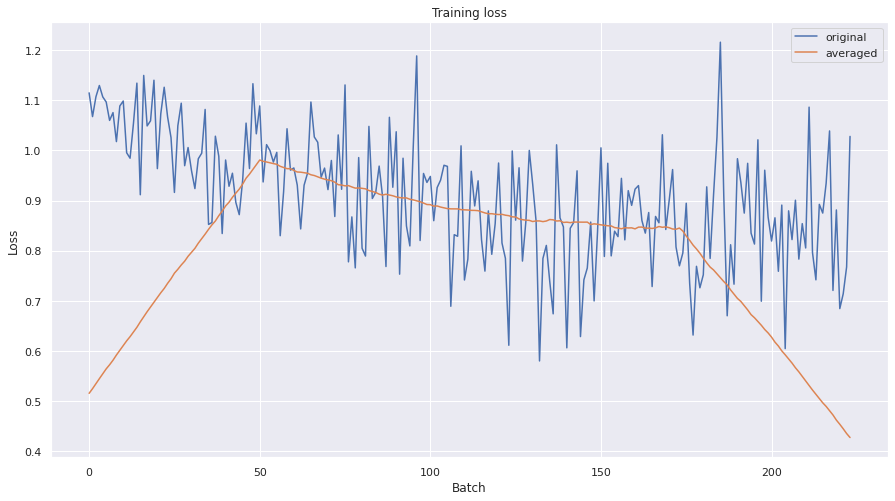

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()